<a href="https://colab.research.google.com/github/Jaime44/WorkSpace/blob/main/models/neural%20network/00_NN_Recommender_system_movie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys

# Comprueba si el código se está ejecutando en Google Colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

path_absolute = ''
if IN_COLAB:
    print("El código se está ejecutando en Google Colab.")
    from google.colab import drive
    import tensorflow as tf
    print("Versión de TensorFlow:", tf.__version__)
    print("Dispositivos disponibles:", tf.config.list_physical_devices())

    drive.mount('/content/drive')
    path_absolute = '/content/drive/Othercomputers/Mi_portátil/TFM/WorkSpace/Models/neural network'

    path_workspace = '/content/drive/Othercomputers/Mi_portátil/TFM/WorkSpace/'

    # Cambia al directorio de tu carpeta en Google Drive
    os.chdir(path_absolute)

    # Lista los archivos y carpetas en el directorio actual
    contenido_carpeta = os.listdir(path_absolute)
    print("Contenido de la carpeta en Google Drive:")
    print(contenido_carpeta)

    # Verificar la GPU
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        print('GPU no encontrada')
    print(f'Encontrada GPU: {device_name}')

    # Habilitar la GPU para TensorFlow
    physical_devices = tf.config.list_physical_devices('GPU')
    if len(physical_devices) > 0:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print('Memoria de la GPU configurada dinámicamente')
    else:
        print('No se encontraron dispositivos GPU configurables')
else:
    print("El código se está ejecutando en un entorno local.")
    path_workspace ='C:/Users/jaime/OneDrive - Universidad de Málaga/Escritorio/UNIR/TFM/WorkSpace/'
    path_absolute = os.getcwd().replace("\\", "/")
    path_absolute = 'C:/Users/jaime/OneDrive - Universidad de Málaga/Escritorio/UNIR/TFM/WorkSpace/Models/neural network'

datasets_path = "/datasets/"
path_absolute = path_absolute+datasets_path


sys.path.append(path_workspace)

El código se está ejecutando en Google Colab.
Versión de TensorFlow: 2.15.0
Dispositivos disponibles: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Contenido de la carpeta en Google Drive:
['00_NN_Recommender_system_movieCOLAB.ipynb', 'movie-recommender-systems-using-neural-network.ipynb', 'nn_rs.ipynb', 'cf-based-recsys-by-low-rank-matrix-factorization_Original.ipynb', 'datasets', 'rec-sys-collaborative-filtering-dl-techniques_Original.ipynb', 'recommender-system-with-artificial-neural-networks.ipynb', 'recommender-system-with-artificial-neural-networks_Original.ipynb', 'movie-recommender-systems-using-neural-network_Original.ipynb', 'cf-based-recsys-by-low-rank-matrix-factorization.ipynb', 'XX_collaborative-filtering-nn.ipynb', 'XX_collaborative-filtering-nn_Original.ipynb', 'nn_rs_colab.ipynb', 'rec-sys-collaborative-filtering-dl-techn

In [2]:
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib as mpl
import Utils.utils as util
import matplotlib.pyplot as plt


from keras import backend as K
from keras.models import Model
from IPython.display import SVG
from wordcloud import WordCloud
from keras.callbacks import EarlyStopping
# from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.layers import Dense,Dropout,Flatten,Embedding,BatchNormalization,Concatenate,Add,Concatenate,Dot,Input,dot,concatenate

In [3]:
def precision(recommended_items, relevant_items):
    # Calculate the intersection of recommended_items and relevant_items
    true_positive = len(set(recommended_items).intersection(set(relevant_items)))

    # Calculate the total number of recommended items
    total_recommended_items = len(recommended_items)

    # Calculate precision
    precision_value = true_positive / total_recommended_items if total_recommended_items > 0 else 0
    return precision_value

# Example usage
recommended_items = [1, 3, 5, 7, 9]
relevant_items = [2, 3, 5, 7, 11, 15, 20]

precision_value = precision(recommended_items, relevant_items)
print(f"Precision: {precision_value:.2f}")


Precision: 0.60


In [4]:
def precisionK(recommended_items, relevant_items, k):
    """
    Calcula la precisión en k (Precision@k) dadas las recomendaciones y los elementos relevantes.

    :param recommended_items: Una lista de los elementos recomendados.
    :param relevant_items: Una lista de los elementos relevantes para el usuario.
    :param k: El número de elementos principales a considerar.
    :return: La precisión en k.
    """
    if k <= 0:
        raise ValueError("k debe ser un entero positivo.")

    if len(recommended_items) == 0:
        return 0

    # Tomamos solo los primeros k elementos recomendados
    recommended_at_k = recommended_items[:k]

    # Contamos el número de elementos relevantes entre los k recomendados
    relevantes_entre_k = sum(1 for item in recommended_at_k if item in relevant_items)

    # Calculamos la precisión en k
    precision_at_k = relevantes_entre_k / k

    return precision_at_k

In [5]:
def recall(recommended_items, relevant_items):
    # Calculate the intersection of recommended_items and relevant_items
    true_positive = len(set(recommended_items).intersection(set(relevant_items)))

    # Calculate the total number of relevant items
    total_relevant_items = len(relevant_items)

    # Calculate recall
    recall_value = true_positive / total_relevant_items if total_relevant_items > 0 else 0
    return recall_value

# Example usage
recommended_items = [1, 3, 5, 7, 9]
relevant_items = [2, 3, 5, 7, 11, 15, 20]

recall_value = recall(recommended_items, relevant_items)
print(f"Recall: {recall_value:.2f}")

Recall: 0.43


In [6]:
def recallK(recommended_items, relevant_items, k):
    """
    Calcula el Recall en k (Recall@k) o Hit Ratio en k (HitRatio@k) dadas las recomendaciones y los elementos relevantes.

    :param recommended_items: Una lista de los elementos recomendados.
    :param relevant_items: Una lista de los elementos relevantes para el usuario.
    :param k: El número de elementos principales a considerar.
    :return: El Recall en k.
    """
    if k <= 0:
        raise ValueError("k debe ser un entero positivo.")

    if len(relevant_items) == 0:
        return 0

    # Tomamos solo los primeros k elementos recomendados
    recommended_at_k = recommended_items[:k]

    # Contamos el número de elementos relevantes entre los k recomendados
    relevantes_entre_k = sum(1 for item in recommended_at_k if item in relevant_items)

    # Calculamos el Recall en k
    recall_at_k = relevantes_entre_k / len(relevant_items)

    return recall_at_k

# Ejemplo de uso
recommended_items_ejemplo = ['a', 'b', 'c', 'd', 'e']
relevant_items_ejemplo = ['b', 'd', 'f']

k_ejemplo = 3

recall_k_ejemplo = recallK(recommended_items_ejemplo, relevant_items_ejemplo, k_ejemplo)
print("Recall@{}: {:.2f}".format(k_ejemplo, recall_k_ejemplo))


Recall@3: 0.33


In [7]:
def mean_reciprocal_rank(recommended_items_list, relevant_items_list):
    if len(recommended_items_list) != len(relevant_items_list):
        raise ValueError("The length of recommended_items_list and relevant_items_list must be the same.")

    reciprocal_ranks = []

    # Iterate through the lists of recommended items and relevant items for each user
    for recommended_items, relevant_items in zip(recommended_items_list, relevant_items_list):
        # print(f"recommended_items --> {recommended_items}")
        # print(f"relevant_items --> {relevant_items}")
        # Find the reciprocal rank for each user
        for rank, item in enumerate(recommended_items, start=1):
          # print(f"rank --> {rank}")
          # print(f"item --> {item}")
          if item in relevant_items:
              reciprocal_ranks.append(1 / rank)
              break
          else:
              reciprocal_ranks.append(0)

    # Calculate the mean reciprocal rank
    mrr = sum(reciprocal_ranks) / len(reciprocal_ranks)
    return mrr

# Example usage
recommended_items_list = [
    [1, 3, 5, 7, 9],
    [2, 4, 6, 8],
    [11, 12, 13, 14, 15, 16, 17]
]

relevant_items_list = [
    [2, 3, 5, 7, 11],
    [1, 4, 6, 8, 9],
    [16, 17, 18, 19, 20]
]

mrr = mean_reciprocal_rank(recommended_items_list, relevant_items_list)
print(f"Mean Reciprocal Rank: {mrr:.2f}")


Mean Reciprocal Rank: 0.12


In [8]:
def average_precision(recommended_items, relevant_items):
    true_positives = 0
    sum_precisions = 0
    # print(f"AVP_recommended_items --> {recommended_items}")
    # print(f"AVP_relevant_items --> {relevant_items}")
    for rank, item in enumerate(recommended_items, start=1):
      # print(f"AVP_rank --> {rank}")
      # print(f"AVP_item --> {item}")
      if item in relevant_items:
          true_positives += 1
          precision_at_rank = true_positives / rank
          sum_precisions += precision_at_rank
      # print(f"AVP_sum_precisions --> {sum_precisions}")

    return sum_precisions / len(relevant_items) if len(relevant_items) > 0 else 0

def mean_average_precision(recommended_items_list, relevant_items_list):
    if len(recommended_items_list) != len(relevant_items_list):
        raise ValueError("The length of recommended_items_list and relevant_items_list must be the same.")

    average_precisions = []

    # Calculate the average precision for each user
    for recommended_items, relevant_items in zip(recommended_items_list, relevant_items_list):
        ap = average_precision(recommended_items, relevant_items)
        average_precisions.append(ap)

    # Calculate the mean average precision across all users
    map_value = sum(average_precisions) / len(average_precisions)
    return round(map_value, 2)

# Example usage
recommended_items_list = [
    [1, 3, 5, 7, 9],
    [2, 4, 6, 8],
    [11, 12, 13, 14, 15, 16, 17]
]

relevant_items_list = [
    [2, 3, 5, 7, 11],
    [1, 4, 6, 8, 9],
    [16, 17, 18, 19, 20]
]

map_value = mean_average_precision(recommended_items_list, relevant_items_list)
print(f"Mean Average Precision: {map_value}")

Mean Average Precision: 0.29


In [9]:
def discounted_cumulative_gain(recommended_items, relevant_items):
    dcg = 0
    # print(f'\ndiscounted_cumulative_gain --> recommended_items {recommended_items}')
    # print(f'discounted_cumulative_gain --> relevant_items {relevant_items}\n')
    for i, item in enumerate(recommended_items, start=1):
        if item in relevant_items:
            dcg += 1 / (math.log2(i + 1))
    return dcg

def ideal_discounted_cumulative_gain(recommended_items, relevant_items):
    # print(f'ideal_discounted_cumulative_gain --> recommended_items {recommended_items}')
    # print(f'ideal_discounted_cumulative_gain --> relevant_items {relevant_items}\n')
    sorted_relevant_items = sorted(relevant_items, key=lambda x: recommended_items.index(x) if x in recommended_items else float('inf'))
    return discounted_cumulative_gain(sorted_relevant_items, relevant_items)

def normalized_discounted_cumulative_gain(recommended_items, relevant_items):
    # print(f'\nnormalized_discounted_cumulative_gain --> recommended_items {recommended_items}')
    # print(f'normalized_discounted_cumulative_gain --> relevant_items {relevant_items}')
    dcg = discounted_cumulative_gain(recommended_items, relevant_items)
    idcg = ideal_discounted_cumulative_gain(recommended_items, relevant_items)

    if idcg == 0:
        return 0
    else:
        return round(dcg / idcg, 2)

def mean_normalized_discounted_cumulative_gain(recommended_items, relevant_items):
  # print(f'\nmean_normalized_discounted_cumulative_gain --> recommended_items {recommended_items}')
  # print(f'mean_normalized_discounted_cumulative_gain --> relevant_items {relevant_items}')
  ndcg_values = [normalized_discounted_cumulative_gain(recommended, relevant)
                  for recommended, relevant in zip(recommended_items, relevant_items)]
  average_ndcg = np.mean(ndcg_values)
  return average_ndcg

# Example usage
recommended_items_list = [
    [1, 3, 5, 7, 9],
    [2, 4, 6, 8],
    [11, 12, 13, 14, 15, 16, 17]
]

relevant_items_list = [
    [2, 3, 5, 7, 11],
    [1, 4, 6, 8, 9],
    [16, 17, 18, 19, 20]
]

ndcg_values = [normalized_discounted_cumulative_gain(recommended, relevant)
               for recommended, relevant in zip(recommended_items_list, relevant_items_list)]

print(f"nDCG values: {ndcg_values}")

average_ndcg = mean_normalized_discounted_cumulative_gain(recommended_items_list, relevant_items_list)
print(f"nDCG promedio: {average_ndcg:.2f}")

nDCG values: [0.53, 0.53, 0.23]
nDCG promedio: 0.43


In [89]:
def catalog_coverage(recommended_items_list, catalog_items):
    # Flatten the list of recommended items and convert it to a set
    unique_recommended_items = set(item for sublist in recommended_items_list for item in sublist)

    # Calculate the intersection of unique recommended items and catalog items
    covered_items = unique_recommended_items.intersection(catalog_items)

    # Calculate the catalog coverage
    coverage = len(covered_items) / len(catalog_items)
    return coverage

# Example usage
recommended_items_list = [
    [1, 3, 5, 7, 9],
    [2, 4, 6, 8],
    [11, 12, 13, 14, 15, 16, 17]
]

catalog_items = set(range(1, 21))

coverage = catalog_coverage(recommended_items_list, catalog_items)
print(f"Catalog Coverage: {coverage}")

Catalog Coverage: 0.8


In [110]:
def prediction_coverage(predicted_ratings, total_users, total_items):

    print(f'predicted_ratings --> {predicted_ratings[0]}\n')
    print(f'total_users --> {total_users}\n')
    print(f'total_items --> {total_items}\n')


    # Count the number of user-item pairs for which the recommendation system can make predictions
    predicted_pairs = sum(len(ratings) for ratings in predicted_ratings)

    print(f'predicted_pairs --> {predicted_pairs}\n')
    # Calculate the total number of possible user-item pairs
    total_possible_pairs = total_users * total_items

    print(f'total_possible_pairs --> {total_possible_pairs}\n')
    # Calculate the prediction coverage
    coverage = predicted_pairs / total_possible_pairs

    print(f'coverage --> {coverage}\n')
    return coverage

# Example usage
predicted_ratings = [
    {1: 3.5, 3: 4.0, 5: 2.5, 7: 3.0, 9: 4.5},
    {2: 4.5, 4: 3.0, 6: 2.0, 8: 3.5},
    {11: 3.5, 12: 4.0, 13: 2.5, 14: 3.0, 15: 4.5, 16: 3.5, 17: 2.0}
]

total_users = 3
total_items = 20

coverage = prediction_coverage(predicted_ratings, total_users, total_items)
print(f"Prediction Coverage: {coverage:.2f}")


predicted_ratings --> {1: 3.5, 3: 4.0, 5: 2.5, 7: 3.0, 9: 4.5}

total_users --> 3

total_items --> 20

predicted_pairs --> 16

total_possible_pairs --> 60

coverage --> 0.26666666666666666

Prediction Coverage: 0.27


In [10]:
               # 1  2  3  4  5  6  7  8
archiqture = [1, 1, 1, 1, 1, 1, 1, 0, 0]

In [11]:
# dataFrame_onehot_encode = pd.read_csv(path_absolute+'data_moviesRating_tgGen_tgUsrs_onehot_encode.csv', sep=',')

# dataFrame_onehot_encode.head()

In [12]:
dataFrame_without_ohe = pd.read_csv(path_absolute+'data_moviesRating_tgGen_tgUsrs.csv')
print(dataFrame_without_ohe.shape)
dataFrame_without_ohe.head()

<ipython-input-12-c633e3f492c3>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  dataFrame_without_ohe = pd.read_csv(path_absolute+'data_moviesRating_tgGen_tgUsrs.csv')


(25000095, 8)


,userId,movieId,tag_by_user,tag_genome,title,genres,timestamp,rating
0,1,296,NaN,"masterpiece, hit men, gratuitous violence, dar...",Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,1147880044,5.0
1,3,296,NaN,"masterpiece, hit men, gratuitous violence, dar...",Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,1439474476,5.0
2,4,296,NaN,"masterpiece, hit men, gratuitous violence, dar...",Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,1573938898,4.0
3,5,296,NaN,"masterpiece, hit men, gratuitous violence, dar...",Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,830786155,4.0
4,7,296,NaN,"masterpiece, hit men, gratuitous violence, dar...",Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,835444730,4.0


In [13]:
# ORDENAR EL DATAFRAME POR LA COLUMNA TIMESTAMP DE MAYOR A MENOR, DE LA CALIFIACIÓN MAS NUEVA A LA MAS ANTIGUA.
dataFrame_sorted_by_rating = dataFrame_without_ohe.copy()

# Ordenar el DataFrame por la columna 'timestamp' de mayor a menor
dataFrame_sorted_by_rating = dataFrame_sorted_by_rating.sort_values(by='timestamp', ascending=False)

In [14]:
def contar_valores_nulos(df):
    # Cuenta los valores nulos en cada columna del DataFrame
    valores_nulos_por_columna = df.isnull().sum()
    # Cuenta los valores nulos en todo el DataFrame
    total_valores_nulos = df.isnull().sum().sum()
    # Imprime la cantidad de valores nulos por columna
    print("Valores nulos por columna:")
    print(valores_nulos_por_columna)
    # Imprime el total de valores nulos en el DataFrame
    print("\nTotal de valores nulos en el dataset:", total_valores_nulos)

def eliminar_filas_nulas(df, columna):
    # Seleccionar las filas con valores nulos en la columna deseada
    filas_con_nulos = df[df[columna].isnull()]
    # Mostrar las filas con valores nulos
    # print("Filas con valores nulos en la columna", columna, ":")
    # print(filas_con_nulos)
    # Eliminar las filas con valores nulos en la columna deseada
    df = df.dropna(subset=[columna])
    return df

In [15]:
# contar_valores_nulos(df)
dataFrame_without_ohe = eliminar_filas_nulas(dataFrame_sorted_by_rating, 'tag_genome')
# contar_valores_nulos(df)
dataFrame_without_ohe = eliminar_filas_nulas(dataFrame_sorted_by_rating, 'tag_by_user')
# contar_valores_nulos(df)

In [16]:
# Filtrar usuarios con al menos x calificaciones
min_n_ratings=50
df_aux = dataFrame_without_ohe.copy()
df_filtered_by_ratings_counts = df_aux.groupby('userId').filter(lambda x: len(x) >= min_n_ratings)
print(df_filtered_by_ratings_counts.shape)
# print(df_filtered['userId'].value_counts().sort_values(ascending=False))
# print(df_filtered['userId'].value_counts().sort_values(ascending=True))
df_filtered_by_ratings_counts.head()


(139327, 8)


,userId,movieId,tag_by_user,tag_genome,title,genres,timestamp,rating
24669606,123527,201594,"country life, jump scares, farmhouse, horror, ...","chase, pg-13, original, fast paced, murder",Brightburn (2019),Drama|Horror|Sci-Fi|Thriller,1574316587,3.0
24620468,47901,72683,"relaxing, river, fate, Criterion, boat, isolation",NaN,Limit (Limite) (1931),Drama,1574302199,4.0
24390005,73725,190401,"Scotland, coverup, netflix, dark, Netflix orig...","original, mentor, catastrophe, silly fun, grea...",Calibre (2018),Thriller,1574300676,3.0
22460648,61610,4036,"Udo Kier, vampire, 1920s, dracula, John Malkov...","vampire, immortality, weird, original, vampires",Shadow of the Vampire (2000),Drama|Horror,1574288547,4.0
24999787,156433,208465,"surreal, chaos, storytelling, screenplay, Dire...",NaN,Jallikattu (2019),Action|Crime|Drama|Thriller,1574286714,4.5


In [17]:
dataFrame = df_filtered_by_ratings_counts.copy()
# dataFrame = dataFrame_onehot_encode.copy()

In [18]:
n_samples = round(dataFrame.shape[0] * 0.05)
dataFrame = dataFrame.sample(n=n_samples, random_state=42)
df = dataFrame.copy()
print(df.shape)
df.head()

(6966, 8)


,userId,movieId,tag_by_user,tag_genome,title,genres,timestamp,rating
9404537,36535,46948,"friends, neighbors, house, 3d, Writer: Pamela ...","children, animation, oscar (best animated feat...",Monster House (2006),Animation|Children|Fantasy|Mystery,1165728620,2.0
1493001,138583,589,"avi, Rated R, tension, moral ambiguity, dvd, s...","scifi, cyborgs, action, science fiction, future",Terminator 2: Judgment Day (1991),Action|Sci-Fi,1053197119,4.5
2744813,82286,2571,"AI, consciousness, Gfei own it, avi, The Chose...","dystopic future, cyberpunk, science fiction, s...","Matrix, The (1999)",Action|Sci-Fi|Thriller,1554084593,4.5
18584076,61094,5500,"ludicrous, Val Kilmer, silly fun, very funny, ...","comedy, parody, funniest movies, hilarious, spoof",Top Secret! (1984),Comedy,1208591164,4.5
10471140,104394,839,"adapted from:comic, tattoo, Nudity (Topless - ...","dark hero, vengeance, sequel, sequels, good se...","Crow: City of Angels, The (1996)",Action|Thriller,1245634861,2.5


In [19]:
# import pandas as pd

# # Supongamos que 'df' es tu DataFrame que contiene las columnas 'userId' y 'movieId'

# # Crear un diccionario para almacenar las ocurrencias de cada par de valores
# ocurrencias = {}

# # Iterar sobre el DataFrame para contar las ocurrencias de cada par de valores
# for index, row in df.iterrows():
#     userId = row['userId']
#     movieId = row['movieId']
#     par_valores = (userId, movieId)
#     ocurrencias[par_valores] = ocurrencias.get(par_valores, 0) + 1

# # Imprimir todas las ocurrencias encontradas
# for par_valores, frecuencia in ocurrencias.items():
#     print(f"El par de valores {par_valores} se repite {frecuencia} veces.")


In [20]:
df = df[~df.duplicated(subset=['userId', 'movieId'], keep='first')]

In [21]:
df.shape

(6966, 8)

## Explore dataset

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6966 entries, 9404537 to 20304281
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   userId       6966 non-null   int64  
 1   movieId      6966 non-null   int64  
 2   tag_by_user  6966 non-null   object 
 3   tag_genome   6471 non-null   object 
 4   title        6966 non-null   object 
 5   genres       6966 non-null   object 
 6   timestamp    6966 non-null   int64  
 7   rating       6966 non-null   float64
dtypes: float64(1), int64(3), object(4)
memory usage: 489.8+ KB


In [23]:
# Valores nulos
print(f"Valores nulos para la columna userId: {df['userId'].isnull().sum()}")
print(f"Valores nulos para la columna rating: {df['rating'].isnull().sum()}")
print(f"Valores nulos para la columna movieId: {df['movieId'].isnull().sum()}")

Valores nulos para la columna userId: 0
Valores nulos para la columna rating: 0
Valores nulos para la columna movieId: 0


In [24]:
# Se cuenta los valores unicos de rating
df['rating'].value_counts()

4.0    1635
3.5    1300
3.0    1000
4.5     937
5.0     817
2.5     493
2.0     363
1.5     171
1.0     131
0.5     119
Name: rating, dtype: int64

In [25]:
# Se cuenta los valores unicos de usuarios
df['userId'].value_counts()

62199     201
6550      111
21096      85
131347     80
33844      78
         ... 
129864      1
33067       1
76718       1
89481       1
68716       1
Name: userId, Length: 855, dtype: int64

In [26]:
# Se cuenta los valores unicos de peliculas
df['movieId'].value_counts()

318       19
296       17
2571      15
2959      14
74458     13
          ..
118696     1
390        1
204698     1
1211       1
133741     1
Name: movieId, Length: 3971, dtype: int64

In [27]:
rango_valores = df['rating'].describe()['min'], df['rating'].describe()['max']
print("Rango de valores cd rating:", rango_valores)

Rango de valores cd rating: (0.5, 5.0)


In [28]:
import pandas as pd

# Suponiendo que tu DataFrame se llame df
# Si ya tienes cargado el DataFrame, no necesitas esta línea
# df = pd.read_csv("nombre_del_archivo.csv")  # Si tus datos están en un archivo CSV

# Calcular el número de calificaciones por usuario
distribucion_calificaciones_por_usuario = df['userId'].value_counts()

# Obtener estadísticas descriptivas
estadisticas_descriptivas = distribucion_calificaciones_por_usuario.describe()

print("Estadísticas descriptivas del número de calificaciones por usuario:")
print(estadisticas_descriptivas)


Estadísticas descriptivas del número de calificaciones por usuario:
count    855.000000
mean       8.147368
std       11.992163
min        1.000000
25%        3.000000
50%        5.000000
75%        9.000000
max      201.000000
Name: userId, dtype: float64


In [29]:
#promedio de calificaciones agrupado por titulos
df.groupby('title')['rating'].mean().sort_values(ascending=False).head(10)

title
Spanking the Monkey (1994)                     5.0
Only Lovers Left Alive (2013)                  5.0
Angel's Egg (Tenshi no tamago) (1985)          5.0
Wild Wild Country (2018)                       5.0
Hackers (1995)                                 5.0
The Face of an Angel (2015)                    5.0
Oslo, August 31st (Oslo, 31. august) (2011)    5.0
Dazed and Confused (1993)                      5.0
One Froggy Evening (1955)                      5.0
Collapse (2009)                                5.0
Name: rating, dtype: float64

In [30]:
# Cuantos generos distintos hay y cuantqas peliculas clasificadas con ese genero entre otros.
if 'genres' in df.columns:
    genres = {}
    def find_genres():
        for genre in df['genres']:
            words = genre.split('|')
            for word in words:
                genres[word] = genres.get(word, 0) + 1
    find_genres()
    # genres['None'] = genres.pop('(no genres listed)')
    genres



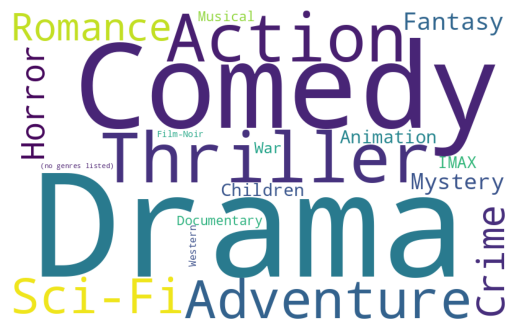

In [31]:
# Nube de palabras para los generos
if 'genres' in df.columns:
    wordcloud = WordCloud(width=800, height=500, background_color = 'white',
                        min_font_size=6, contour_color='black', contour_width=2).generate_from_frequencies(genres)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [32]:
#Peliculas más puntuadas
df_n_ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
df_n_ratings['total ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
df_n_ratings.rename(columns = {'rating': 'mean ratings'}, inplace=True)
df_n_ratings.sort_values('total ratings', ascending=False).head(10)

,mean ratings,total ratings
title,,
"Shawshank Redemption, The (1994)",4.131579,19
Pulp Fiction (1994),4.000000,17
"Matrix, The (1999)",4.300000,15
Fight Club (1999),4.535714,14
Children of Men (2006),4.076923,13
Shutter Island (2010),4.192308,13
"Godfather, The (1972)",4.538462,13
"Usual Suspects, The (1995)",4.166667,12
Alien (1979),4.666667,12


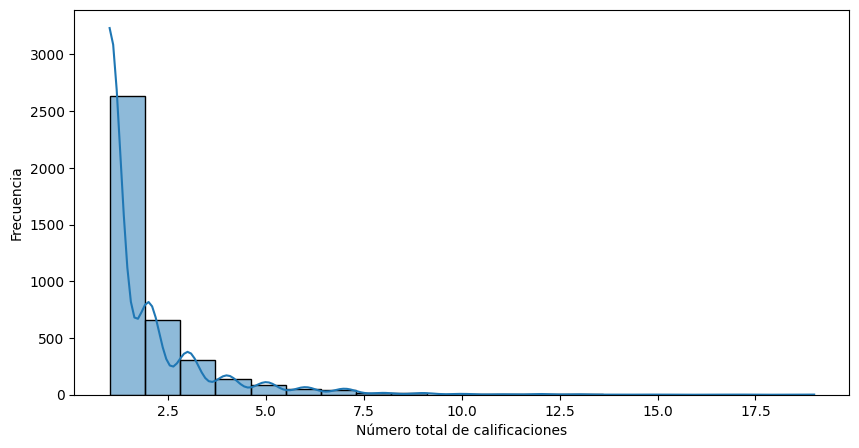

In [33]:
# histograma de la distribución de frecuencia del número total de calificaciones en el DataFrame
plt.figure(figsize=(10,5))
sns.histplot(df_n_ratings['total ratings'], bins=20, kde=True)  # kde=True incluye la estimación de densidad kernel
plt.xlabel('Número total de calificaciones')
plt.ylabel('Frecuencia')
plt.show()

<ipython-input-34-3a67f88d42ea>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="rating", data=pd.DataFrame(dataFrame_without_ohe['rating']) , palette="viridis")


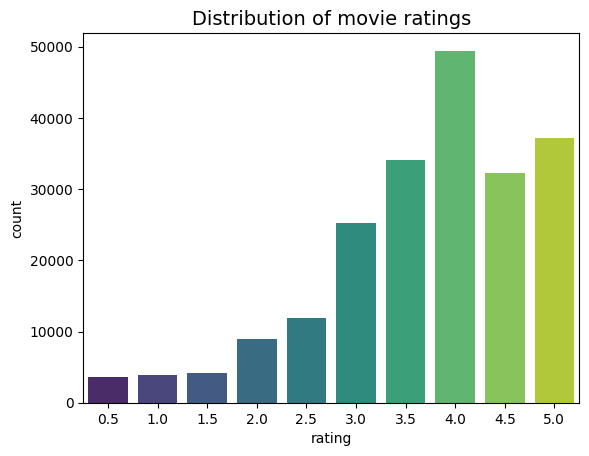

In [34]:
sns.countplot(x="rating", data=pd.DataFrame(dataFrame_without_ohe['rating']) , palette="viridis")
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

In [35]:
# Calificaciones promedio más altas en función de la columna 'mean ratings'.
df_n_ratings.sort_values('mean ratings', ascending=False).head(10)

,mean ratings,total ratings
title,,
Spanking the Monkey (1994),5.0,1
Only Lovers Left Alive (2013),5.0,1
Angel's Egg (Tenshi no tamago) (1985),5.0,1
Wild Wild Country (2018),5.0,2
Hackers (1995),5.0,1
The Face of an Angel (2015),5.0,1
"Oslo, August 31st (Oslo, 31. august) (2011)",5.0,1
Dazed and Confused (1993),5.0,1
One Froggy Evening (1955),5.0,1


In [36]:
print('Nº total de usuarios que han valorado con 5,0 : ', len(df_n_ratings.loc[df_n_ratings['mean ratings'] == 5]), '\n')
print('Nº total de usuarios individuales que han valorado con 5,0 : ', len(df_n_ratings.loc[(df_n_ratings['mean ratings'] == 5)
                                                                           & (df_n_ratings['total ratings'] == 1)]))

Nº total de usuarios que han valorado con 5,0 :  223 

Nº total de usuarios individuales que han valorado con 5,0 :  210


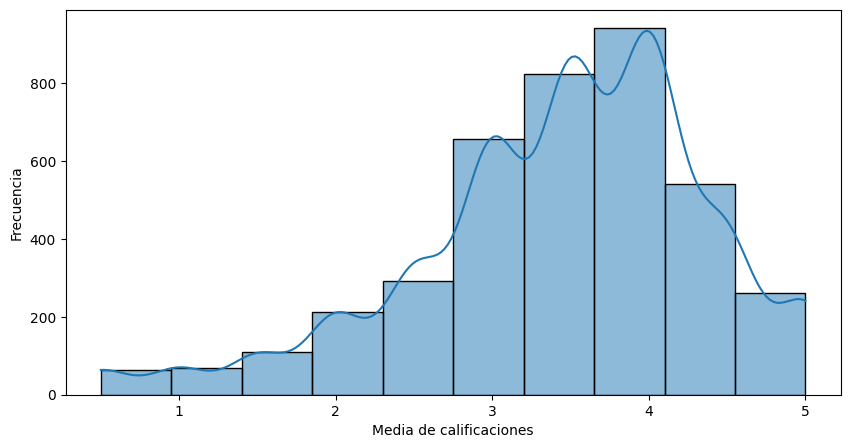

In [37]:
plt.figure(figsize=(10,5))
sns.histplot(df_n_ratings['mean ratings'], bins=10, kde=True)
plt.xlabel('Media de calificaciones')
plt.ylabel('Frecuencia')
plt.show()

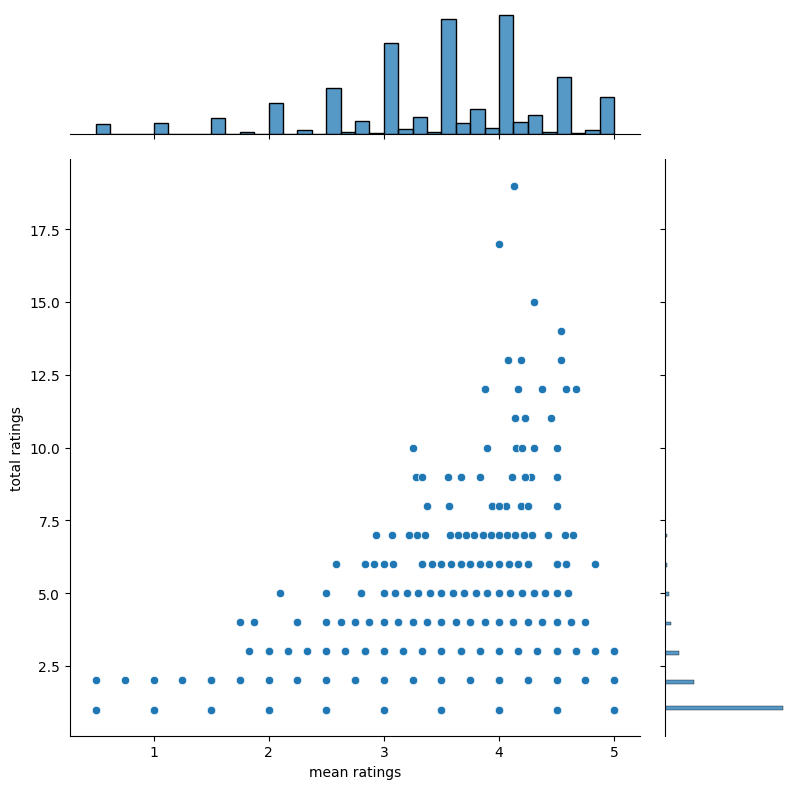

In [38]:
# Mean Ratings vs Total Number of Ratings
sns.jointplot(x='mean ratings', y='total ratings', data=df_n_ratings, height=8, ratio=4)


## MODELS

In [39]:
df.head(3)

,userId,movieId,tag_by_user,tag_genome,title,genres,timestamp,rating
9404537,36535,46948,"friends, neighbors, house, 3d, Writer: Pamela ...","children, animation, oscar (best animated feat...",Monster House (2006),Animation|Children|Fantasy|Mystery,1165728620,2.0
1493001,138583,589,"avi, Rated R, tension, moral ambiguity, dvd, s...","scifi, cyborgs, action, science fiction, future",Terminator 2: Judgment Day (1991),Action|Sci-Fi,1053197119,4.5
2744813,82286,2571,"AI, consciousness, Gfei own it, avi, The Chose...","dystopic future, cyberpunk, science fiction, s...","Matrix, The (1999)",Action|Sci-Fi|Thriller,1554084593,4.5


In [40]:
df_aux = df.copy()
if 'genres' not in df.columns:
    columnas_deseadas = [col for col in df.columns if col not in ['tag_by_user', 'tag_genome', 'title', 'timestamp']]
    df_aux = df.loc[:, columnas_deseadas]
    print(df_aux.head())

In [41]:

# La asignación de índices únicos y la posterior división del DataFrame en conjuntos de entrenamiento y
# prueba pueden ser necesarias por varias razones en el contexto de modelos de recomendación y
# aprendizaje automático en general:

# Índices numéricos: Algunos algoritmos y modelos de aprendizaje automático requieren que las
# entradas sean números enteros. Al asignar índices únicos a los usuarios y películas,
# se asegura de que cada entidad esté representada por un identificador numérico único,
# lo que facilita el procesamiento por parte de los modelos.

# Consistencia en los datos de entrada: Al asignar índices únicos y transformar los datos originales,
# se crea una representación consistente y única para cada usuario y película en el conjunto de datos.
# Esto facilita el manejo y la interpretación de los datos durante el preprocesamiento y el entrenamiento
# del modelo.

# Reproducibilidad: La división aleatoria del DataFrame en conjuntos de entrenamiento y
# prueba utilizando np.random.rand() con una semilla (random_state) proporciona reproducibilidad.
# Esto significa que si vuelves a ejecutar el código con la misma semilla, obtendrás la misma
# división de datos, lo que es útil para comparar resultados y depurar el código.

# Evaluación del modelo: La división en conjuntos de entrenamiento y prueba es esencial para
# evaluar el rendimiento del modelo. El conjunto de entrenamiento se utiliza para entrenar el modelo,
# mientras que el conjunto de prueba se reserva para evaluar su rendimiento en datos no vistos.

# En resumen, estas operaciones son prácticas comunes en el preprocesamiento de datos para modelos
# de aprendizaje automático, especialmente cuando se trata de conjuntos de datos que contienen
# variables categóricas o identificadores que deben ser representados de manera numérica y
# cuando se busca garantizar la consistencia y la reproducibilidad en el procesamiento de datos.


# userId	movieId	timestamp_rt	tag_by_user	timestamp_tags	gen_tag	title	genres	tagId	relevance	rating
# df_aux = df_aux[['userId', 'movieId','rating']]

# Crear diccionarios de asignación de índices únicos
user_unique_ids = df_aux['userId'].unique()
movie_unique_ids = df_aux['movieId'].unique()

userid2idx = {user_id: idx for idx, user_id in enumerate(user_unique_ids)}
movieid2idx = {movie_id: idx for idx, movie_id in enumerate(movie_unique_ids)}

# Aplicar la asignación de índices únicos al DataFrame
df_aux['userId'] = df_aux['userId'].apply(lambda x: userid2idx[x])
df_aux['movieId'] = df_aux['movieId'].apply(lambda x: movieid2idx[x])

# Dividir dataset en entrenamiento y test
if 'genres' in df.columns:
    X = df_aux[['userId', 'movieId', 'genres']]  # UserId y movieId
    Y = df_aux['rating']                # rating
else:
    df_except_last = df.iloc[:, :-1]
    X = df_aux.iloc[:, :-1]
    Y = df_aux['rating']


x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Resetear los índices de x_train y x_test
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

n_genres = 19
print(f'Usuarios unicos: {len(user_unique_ids)} y peliculas unicas {len(movie_unique_ids)}')
print(x_train.shape , x_test.shape)

Usuarios unicos: 855 y peliculas unicas 3971
(5572, 3) (1394, 3)


In [42]:
x_train

,userId,movieId,genres
0,727,3006,Horror|Sci-Fi
1,41,44,Animation|Children
2,844,159,Horror|Sci-Fi
3,99,1751,Sci-Fi
4,112,846,Comedy
...,...,...,...
5567,100,2590,Documentary
5568,564,413,Comedy|Drama|Romance
5569,829,3265,Animation|Comedy|Horror|Musical
5570,112,3338,Drama|Fantasy|Thriller


In [43]:
y_train

0       3.5
1       4.0
2       5.0
3       4.0
4       2.0
       ... 
5567    3.0
5568    3.0
5569    5.0
5570    2.5
5571    3.0
Name: rating, Length: 5572, dtype: float64

### Definicicón de parametros

In [44]:
# Definición del número de factores latentes
n_latent_factors = 10
# learning_rate = 5e-4
lr = 1e-3
#Función de perdida
loss_function = 'mse'
#Bartch
batch_size = 64
#Epoch
epochs = 150
#Paciencia early stopping
pte = 3

In [45]:
es = EarlyStopping(monitor="val_loss",
                   mode="min",
                   verbose=1,
                   patience=pte)

In [46]:
# Deprecated
# def train_model(model):
#     # Entrenar el modelo y obtener el objeto history
#     history = model.fit(x=[x_train['userId'], x_train['movieId']], y=y_train,
#                         batch_size= batch_size, epochs=epochs, verbose= 1,
#                         validation_data=([x_test['userId'], x_test['movieId']], y_test),
#                         callbacks=[es])
#     return history

In [47]:
def train_model(model, x=None, y=None, x_test=None, y_test=None):
    # Definir los datos de entrada si no se proporcionan
    if x is None:
        x = [x_train['userId'], x_train['movieId']]
    if y is None:
        y = y_train
    if x_test is None:
        x_test = [x_test['userId'], x_test['movieId']] if x_test is not None else None  # Corrección aquí
    if y_test is None:
        y_test = y_test

    # Entrenar el modelo y obtener el objeto history
    history = model.fit(x=x, y=y,
                        batch_size=batch_size, epochs=epochs, verbose=1,
                        validation_data=(x_test, y_test),
                        callbacks=[es])
    return history


In [48]:
def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    fig, ax1 = plt.subplots(figsize=(6, 4))

    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(loss, 'r--', label='Training Loss')
    ax1.plot(val_loss, 'b-', label='Validation Loss')
    ax1.tick_params(axis='y', labelcolor=color)

    # Añadir leyendas
    ax1.legend(loc='upper left')

    fig.tight_layout()
    plt.title('Model Loss and Accuracy')
    plt.show()

### Arquitectura 1

In [49]:
K.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [50]:
# Obtención del número único de usuarios y películas en el conjunto de datos de calificaciones
n_users, n_movies = len(df['userId'].unique()), len(df['movieId'].unique())

# Definición de la entrada del usuario
user_input = Input(shape=(1,), name='User_Input')

# Creación de la capa de embedding para usuarios
user_embeddings = Embedding(input_dim=n_users, output_dim=n_latent_factors, input_length=1,
                            name='User_Embedding')(user_input)
user_vector = Flatten(name='User_Vector')(user_embeddings)

# Definición de la entrada de la película
movie_input = Input(shape=(1,), name='Movie_Input')

# Creación de la capa de embedding para películas
movie_embeddings = Embedding(input_dim=n_movies, output_dim=n_latent_factors, input_length=1,
                             name='Movie_Embedding')(movie_input)
movie_vector = Flatten(name='Movie_Vector')(movie_embeddings)

# Combinación de los vectores de usuario y película mediante el producto punto
merged_vectors = dot([user_vector, movie_vector], name='Dot_Product', axes=1)

# Creación del modelo utilizando Model API de Keras
model_a1 = Model([user_input, movie_input], merged_vectors)

model_a1.summary()
# Visualizar el modelo de Keras en formato DOT y luego lo convierte a formato SVG para mostrarlo
# SVG(model_to_dot( model_a1,  show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

#Compilar modelo SGD,Adagrad,Adadelta,RMSprop
model_a1.compile(loss=loss_function, optimizer = Adam(learning_rate=lr) )

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 User_Input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 Movie_Input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 User_Embedding (Embedding)  (None, 1, 10)                8550      ['User_Input[0][0]']          
                                                                                                  
 Movie_Embedding (Embedding  (None, 1, 10)                39710     ['Movie_Input[0][0]']         
 )                                                                                            

### Arquitectura 2

In [51]:
K.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [52]:
# Obtener el número único de películas y usuarios en el DataFrame
n_movies = len(df['movieId'].unique())
n_users = len(df['userId'].unique())

# Definir la capa de entrada para el usuario con un solo valor entero (userId)
user_input = Input(shape=(1,), name='user_input', dtype='int64')

# Crear la capa de embedding para usuarios
user_embedding = Embedding(n_users, n_latent_factors, name='user_embedding')(user_input)
user_vec = Flatten(name='FlattenUsers')(user_embedding)  # Aplanar la salida de la capa de embedding
user_vec = Dropout(0.40)(user_vec)  # Aplicar Dropout para regularización

# Definir la capa de entrada para la película con un solo valor entero (movieId)
movie_input = Input(shape=(1,), name='movie_input', dtype='int64')

# Crear la capa de embedding para películas
movie_embedding = Embedding(n_movies, n_latent_factors, name='movie_embedding')(movie_input)
movie_vec = Flatten(name='FlattenMovies')(movie_embedding)  # Aplanar la salida de la capa de embedding
movie_vec = Dropout(0.40)(movie_vec)  # Aplicar Dropout para regularización

# Calcular la similitud entre los vectores de usuario y película mediante el producto punto
similarity = dot([user_vec, movie_vec], name='Similarity-Dot-Product', axes=1)

# Definir una capa de red neuronal para procesar la similitud calculada
nn_inp = Dense(96, activation='relu')(similarity)
nn_inp = Dropout(0.4)(nn_inp)  # Aplicar Dropout para regularización
# nn_inp = BatchNormalization()(nn_inp)  # Normalización por lotes (comentada, opcional)
nn_inp = Dense(1, activation='relu')(nn_inp)

# Crear el modelo utilizando Model API de Keras
model_a2 = Model([user_input, movie_input], nn_inp)
model_a2.summary()  # Mostrar resumen del modelo en términos de parámetros y capas

# Compilar el modelo con la función de pérdida y el optimizador especificados
model_a2.compile(loss=loss_function, optimizer= Adam(learning_rate=lr) )


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 movie_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding (Embedding)  (None, 1, 10)                8550      ['user_input[0][0]']          
                                                                                                  
 movie_embedding (Embedding  (None, 1, 10)                39710     ['movie_input[0][0]']         
 )                                                                                            

### Arquitectura 3

In [53]:
K.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [54]:
# Obtener el número único de películas y usuarios en el DataFrame
n_movies = len(df['movieId'].unique())
n_users = len(df['userId'].unique())

# Definir la capa de entrada para el usuario con un solo valor entero (userId)
user_input = Input(shape=(1,), name='User_Input')

# Crear la capa de embedding para usuarios
user_embeddings = Embedding(input_dim=n_users+1, output_dim=n_latent_factors, input_length=1, name='User_Embedding')(user_input)
user_vector = Flatten(name='User_Vector')(user_embeddings)  # Aplanar la salida de la capa de embedding

# Definir la capa de entrada para la película con un solo valor entero (movieId)
movie_input = Input(shape=(1,), name='Movie_input')

# Crear la capa de embedding para películas
movie_embeddings = Embedding(input_dim=n_movies+1, output_dim=n_latent_factors, input_length=1, name='Movie_Embedding')(movie_input)
movie_vector = Flatten(name='Movie_Vector')(movie_embeddings)  # Aplanar la salida de la capa de embedding

# Concatenar los vectores de usuario y película
merged_vectors = concatenate([user_vector, movie_vector], name='Concatenation')

# Capa densa con 100 unidades y función de activación ReLU
dense_layer_1 = Dense(100, activation='relu')(merged_vectors)

# Aplicar Dropout para regularización
dense_layer_3 = Dropout(0.5)(dense_layer_1)

# Capa densa de salida con 1 unidad
dense_layer_2 = Dense(1)(dense_layer_3)

# Crear el modelo utilizando Model API de Keras
model_a3 = Model([user_input, movie_input], dense_layer_2)

# Compilar el modelo con la función de pérdida, el optimizador y métricas especificados
model_a3.compile(loss=loss_function, optimizer=Adam(learning_rate=lr), metrics=['accuracy'])
model_a3.summary()  # Mostrar resumen del modelo en términos de parámetros y capas


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 User_Input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 Movie_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 User_Embedding (Embedding)  (None, 1, 10)                8560      ['User_Input[0][0]']          
                                                                                                  
 Movie_Embedding (Embedding  (None, 1, 10)                39720     ['Movie_input[0][0]']         
 )                                                                                            

### Arquitectura 4

In [55]:
K.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [56]:
# Definición de la entrada del usuario (user_input)
user_input = Input(shape=[1], name='user')  # Capa de entrada para la información del usuario.
# print(f"User Input Shape: {user_input.shape}")

# Creación de la capa de embedding para usuarios (user_embedding)
user_embedding = Embedding(input_dim=n_users + 1, output_dim=n_latent_factors, name='user_embedding')(user_input)
# La capa de embedding asigna a cada usuario un vector en el espacio de factores latentes.
# print(f"User Embedding Shape: {user_embedding.shape}")

# Aplanamiento de la capa de embedding para usuarios (user_vec)
user_vec = Flatten(name='flatten_users')(user_embedding)
# Se aplana el embedding para obtener un vector unidimensional que representa al usuario en el espacio de factores latentes.
# print(f"Flattened User Vector Shape: {user_vec.shape}")

# Definición de la entrada de la película (movie_input)
movie_input = Input(shape=[1], name='movie')  # Capa de entrada para la información de la película.
# print(f"Movie Input Shape: {movie_input.shape}")

# Creación de la capa de embedding para películas (movie_embedding)
movie_embedding = Embedding(input_dim=n_movies + 1, output_dim=n_latent_factors, name='movie_embedding')(movie_input)
# La capa de embedding asigna a cada película un vector en el espacio de factores latentes.
# print(f"Movie Embedding Shape: {movie_embedding.shape}")

# Aplanamiento de la capa de embedding para películas (movie_vec)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)
# Se aplana el embedding para obtener un vector unidimensional que representa la película en el espacio de factores latentes.
# print(f"Flattened Movie Vector Shape: {movie_vec.shape}")

# Cálculo del producto punto entre los vectores de película y usuario (product)
product = dot([movie_vec, user_vec], axes=1)
# El modelo calcula el producto punto entre los vectores de película y usuario para predecir las calificaciones.
# print(f"Product Shape: {product.shape}")

# Definición del modelo (model)
model_a4 = Model(inputs=[user_input, movie_input], outputs=product)

# Compilación del modelo con la función de pérdida y optimizador
model_a4.compile(loss=loss_function, optimizer = Adam(learning_rate=lr) )

model_a4.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 movie (InputLayer)          [(None, 1)]                  0         []                            
                                                                                                  
 user (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 movie_embedding (Embedding  (None, 1, 10)                39720     ['movie[0][0]']               
 )                                                                                                
                                                                                                  
 user_embedding (Embedding)  (None, 1, 10)                8560      ['user[0][0]']            

### Arquitectura 5

In [57]:
K.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [58]:
# Definir la entrada del usuario y su embedding
user_input = Input(shape=[1], name='user')
user_embedding = Embedding(input_dim=n_users + 1, output_dim=n_latent_factors, name='user_embedding')(user_input)
user_vec = Flatten(name='flatten_users')(user_embedding)

# Definir la entrada de la película y su embedding
movie_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(input_dim=n_movies + 1, output_dim=n_latent_factors, name='movie_embedding')(movie_input)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)

# Concatenar los embeddings de usuario y película
concatenated = concatenate([user_vec, movie_vec], name='Concatenation')

# Añadir capas Dense con activación ReLU
dense_layer1 = Dense(128, activation='relu')(concatenated)
dense_layer2 = Dense(64, activation='relu')(dense_layer1)
dense_layer3 = Dense(32, activation='relu')(dense_layer2)

# Capa de salida con activación lineal
output = Dense(1, activation='linear')(dense_layer3)

# Crear el modelo con métrica R cuadrado
model_a5 = Model(inputs=[user_input, movie_input], outputs=output)

# Compilación del modelo con la función de pérdida y optimizador
model_a5.compile(loss=loss_function, optimizer = Adam(learning_rate=lr) )

model_a5.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 movie (InputLayer)          [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding (Embedding)  (None, 1, 10)                8560      ['user[0][0]']                
                                                                                                  
 movie_embedding (Embedding  (None, 1, 10)                39720     ['movie[0][0]']               
 )                                                                                            

### Arquitectura 6

In [59]:
K.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [60]:
user_input = Input(shape=(1,), name="user_id", dtype=tf.int32)
item_input = Input(shape=(1,), name="item_id", dtype=tf.int32)

user_embedding = Embedding(n_users,
                                  n_latent_factors,
                                  name="user_emb")(user_input)

user_bias = Embedding(n_users, 1, name="user_bias")(user_input)

item_embedding = Embedding(n_movies,
                                  n_latent_factors,
                                  name="item_emb")(item_input)
item_bias = Embedding(n_movies, 1, name="item_bias")(item_input)

user_vector = Flatten()(user_embedding)
item_vector = Flatten()(item_embedding)

dot_user_item = Dot(name="dot", axes=1)([user_vector, item_vector])
output = Add(name="add")([dot_user_item, user_bias, item_bias])
output = Flatten(name="flat")(output)

model_a6 = Model([user_input, item_input], output, name="model_x")

model_a6.compile(loss=loss_function, optimizer = Adam(learning_rate=lr) )

model_a6.summary()

Model: "model_x"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_id (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 item_id (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 user_emb (Embedding)        (None, 1, 10)                8550      ['user_id[0][0]']             
                                                                                                  
 item_emb (Embedding)        (None, 1, 10)                39710     ['item_id[0][0]']             
                                                                                            

In [61]:
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Definir las métricas personalizadas en TensorFlow/Keras
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def mae(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def mape(y_true, y_pred):
    return tf.reduce_mean(tf.abs((y_true - y_pred) / y_true)) * 100

def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def pearson_corr(y_true, y_pred):
    # Convertir y_pred a tipo float64
    y_pred = y_pred.astype(np.float64)
    # Calcular la correlación de Pearson
    return tfp.stats.correlation(y_true, y_pred, sample_axis=0, event_axis=1)


In [62]:
def calcular_metricas(model, x_test, y_test):
    # Obtener predicciones del modelo
    predictions = model.predict(x_test)

    # Aplanar predicciones
    predictions = predictions.ravel()

    # Calcular métricas
    rmse_val = rmse(y_test, predictions)
    mae_val = mae(y_test, predictions)
    mape_val = mape(y_test, predictions)
    mse_val = mse(y_test, predictions)
    r2_val = r2_score(y_test, predictions)
    # pearson_corr_val = pearson_corr(y_test, predictions)

    # Imprimir métricas
    print("\tRMSE:", rmse_val.numpy())
    print("\tMAE:", mae_val.numpy())
    print("\tMSE:", mse_val.numpy())
    print("\tR2 Score:", r2_val)
    print(f"\tMAPE: {mape_val.numpy()} %")
    # print("Pearson Correlation:", pearson_corr_val)

375/375 [==============================] - 1s 1ms/step:

Indica que se realizaron 375 iteraciones o pasos durante el proceso de evaluación, y cada iteración tardó aproximadamente 1 milisegundo.

1. Mean Squared Error (MSE): 3.0927204499125063:

El MSE es una medida del promedio de los cuadrados de las diferencias entre las predicciones del modelo y los valores reales. En este caso, un MSE de 3.09 indica que las predicciones tienden a desviarse, en promedio, al cuadrado de 3.09 unidades de la verdad.

2. Root Mean Squared Error (RMSE): 1.7586132178260534:

El RMSE es simplemente la raíz cuadrada del MSE. En este caso, un RMSE de 1.76 significa que, en promedio, las predicciones tienden a desviarse alrededor de 1.76 unidades de la verdad.

3. R Squared: -1.8672807452362834:

El R cuadrado (R2) es una medida de la proporción de la varianza en la variable dependiente que es predecible a partir de las variables independientes. Un valor negativo de R2 no es común y sugiere que el modelo no es apropiado para estos datos, ya que es peor que simplemente predecir la media de los datos observados.

4. Pearson Correlation: 0.3082110202566218:

La correlación de Pearson es una medida de la fuerza y dirección de la relación lineal entre dos variables. Un valor de 0.31 indica una correlación positiva débil. Sin embargo, la correlación por sí sola no proporciona una imagen completa y debe interpretarse junto con otras métricas.

En general, estas métricas sugieren que el modelo puede no estar funcionando tan bien en tus datos de prueba. El MSE y RMSE indican el error absoluto promedio, y un R2 negativo sugiere que el modelo no está explicando la varianza de los datos de manera efectiva. La correlación de Pearson, aunque positiva, es relativamente baja. Puedes considerar ajustar tu modelo o explorar otras métricas y técnicas para mejorar su rendimiento.

Basándome en los resultados proporcionados, puedo hacer algunas observaciones:

1. **Precision: 0.20:** La precisión es relativamente baja (20%). Esto podría indicar que, en promedio, solo el 20% de los elementos recomendados son relevantes para los usuarios. Una precisión más alta sería preferible.

2. **Recall: 1.0:** El recall es alto (100%). Esto sugiere que el modelo ha identificado todos los elementos relevantes para los usuarios en el conjunto de prueba. Aunque un recall del 100% es positivo, la baja precisión indica que también hay elementos irrelevantes en las recomendaciones.

3. **Mean Reciprocal Rank (MRR): 1.0:** El MRR es 1.0, lo que indica que, en promedio, el elemento relevante para cada usuario está en la posición 1 de las recomendaciones. Esto es una señal positiva, ya que un MRR de 1.0 sugiere que el modelo está dando la máxima prioridad a los elementos relevantes.

4. **Mean Average Precision (MAP): 1.0:** Un MAP de 1.0 indica que el modelo proporciona la máxima precisión para cada usuario, considerando todas las posiciones de las recomendaciones. Esto es un buen indicador de rendimiento.

5. **Coverage: 8.33e-05:** La cobertura es muy baja (0.0083%). Esto podría significar que el modelo tiene un conjunto limitado de elementos recomendados en comparación con el conjunto total de elementos posibles. Una mayor cobertura sería deseable para garantizar que el modelo pueda recomendar una amplia variedad de elementos.

En resumen, el modelo tiene un recall perfecto y una priorización efectiva de los elementos relevantes, pero la baja precisión y cobertura indican áreas donde podría mejorarse. Es crucial equilibrar la precisión y la cobertura para garantizar que el modelo proporcione recomendaciones relevantes y diversificadas.

In [63]:
# https://medium.com/decathlondigital/building-a-rnn-recommendation-engine-with-tensorflow-505644aa9ff3

# https://medium.com/@karina.condeixa/building-a-ranking-based-recommendations-system-e3adeb2c00f7

# https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54

# https://towardsdatascience.com/evaluation-metrics-for-recommendation-systems-an-overview-71290690ecba

# https://sdsawtelle.github.io/blog/output/mean-average-precision-MAP-for-recommender-systems.html?source=post_page-----71290690ecba--------------------------------

### Arquitectura 7

In [64]:
K.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [65]:
hidden_units = [128, 64]

user_input = Input(shape=(1,), name="user_id", dtype=tf.int32)
item_input = Input(shape=(1,), name="item_id", dtype=tf.int32)
user_embedding = Embedding(n_users,
                                  n_latent_factors,
                                  name="user_emb")(user_input)
item_embedding = Embedding(n_movies,
                                  n_latent_factors,
                                  name="item_emb")(item_input)

concatenated = Concatenate(name="concat")([user_embedding, item_embedding])
out = Flatten(name="flat")(concatenated)

for n_hidden in hidden_units:
    out = Dense(n_hidden,
                       activation="relu")(out)
    out = Dropout(0.4)(out)
    out = BatchNormalization()(out)

out = Dense(1, activation="sigmoid", name="prediction")(out)

model_a7 = Model(inputs = [user_input, item_input],
                      outputs = out, name="model_y")

model_a7.compile(loss=loss_function, optimizer = Adam(learning_rate=lr) )

model_a7.summary()

Model: "model_y"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_id (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 item_id (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 user_emb (Embedding)        (None, 1, 10)                8550      ['user_id[0][0]']             
                                                                                                  
 item_emb (Embedding)        (None, 1, 10)                39710     ['item_id[0][0]']             
                                                                                            

### Arquitectura 8

In [66]:
K.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [67]:
import numpy as np
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Concatenate, Dense
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

# Supongamos que tienes tus datos en las matrices 'usuarios', 'peliculas', 'generos' y 'calificaciones'
# 'usuarios', 'peliculas' y 'generos' son listas de IDs de usuarios, películas y géneros, respectivamente
# 'calificaciones' es una lista de calificaciones correspondientes a cada par usuario-película

# Convertir los datos de género a una lista de listas
generos_list = [generos.split('|') for generos in df_aux['genres']]

# Inicializar y ajustar el codificador one-hot
mlb = MultiLabelBinarizer()
generos_one_hot = mlb.fit_transform(generos_list)

#------------------------------------------------------------------------------
# # Asignar índices únicos a usuarios y películas
# user_unique_ids = df_aux['userId'].unique()
# movie_unique_ids = df_aux['movieId'].unique()

# userid2idx = {user_id: idx for idx, user_id in enumerate(user_unique_ids)}
# movieid2idx = {movie_id: idx for idx, movie_id in enumerate(movie_unique_ids)}

# # Aplicar la asignación de índices únicos al DataFrame
# df_aux['userId'] = df_aux['userId'].apply(lambda x: userid2idx[x])
# df_aux['movieId'] = df_aux['movieId'].apply(lambda x: movieid2idx[x])

# # Dividir dataset en entrenamiento y test
# x_train, x_test, y_train, y_test = train_test_split(df_aux[['userId', 'movieId', 'genres']], df_aux['rating'], test_size=0.2, random_state=42)

# # Resetear los índices de x_train y x_test
# x_train.reset_index(drop=True, inplace=True)
# x_test.reset_index(drop=True, inplace=True)
#------------------------------------------------------------------------------

# Definir las capas de entrada
input_usuario = Input(shape=[1])
input_pelicula = Input(shape=[1])
input_genero = Input(shape=[generos_one_hot.shape[1]])  # Número de géneros únicos

# Definir las capas de embedding para usuarios y películas
embedding_usuario = Embedding(input_dim=len(user_unique_ids), output_dim=50)(input_usuario)
embedding_pelicula = Embedding(input_dim=len(movie_unique_ids), output_dim=50)(input_pelicula)

# Aplanar las capas de embedding
flat_usuario = Flatten()(embedding_usuario)
flat_pelicula = Flatten()(embedding_pelicula)

# Concatenar las capas de embedding con los géneros codificados one-hot
concat = Concatenate()([flat_usuario, flat_pelicula, input_genero])

# Agregar capas densas
dense1 = Dense(128, activation='relu')(concat)
dense2 = Dense(64, activation='relu')(dense1)
output = Dense(1)(dense2)

# Compilar el modelo
modelo_a8 = Model(inputs=[input_usuario, input_pelicula, input_genero], outputs=output)
# Generar la codificación one-hot de los géneros solo para las filas relevantes
generos_one_hot_train = generos_one_hot[x_train.index]
generos_one_hot_test = generos_one_hot[x_test.index]

# Compilar el modelo
modelo_a8.compile(loss='mse', optimizer='adam', metrics=['mae'])
modelo_a8.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 50)                42750     ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 50)                198550    ['input_2[0][0]']             
                                                                                              

# A1

Epoch 1/150
88/88 [==============================] - 2s 8ms/step - loss: 13.6830 - val_loss: 13.8626
Epoch 2/150
88/88 [==============================] - 0s 5ms/step - loss: 13.6646 - val_loss: 13.8626
Epoch 3/150
88/88 [==============================] - 0s 6ms/step - loss: 13.6328 - val_loss: 13.8627
Epoch 4/150
88/88 [==============================] - 0s 4ms/step - loss: 13.5712 - val_loss: 13.8624
Epoch 5/150
88/88 [==============================] - 0s 3ms/step - loss: 13.4627 - val_loss: 13.8615
Epoch 6/150
88/88 [==============================] - 0s 4ms/step - loss: 13.2934 - val_loss: 13.8601
Epoch 7/150
88/88 [==============================] - 0s 3ms/step - loss: 13.0578 - val_loss: 13.8574
Epoch 8/150
88/88 [==============================] - 0s 3ms/step - loss: 12.7574 - val_loss: 13.8551
Epoch 9/150
88/88 [==============================] - 0s 3ms/step - loss: 12.3968 - val_loss: 13.8523
Epoch 10/150
88/88 [==============================] - 0s 3ms/step - loss: 11.9849 - val_los

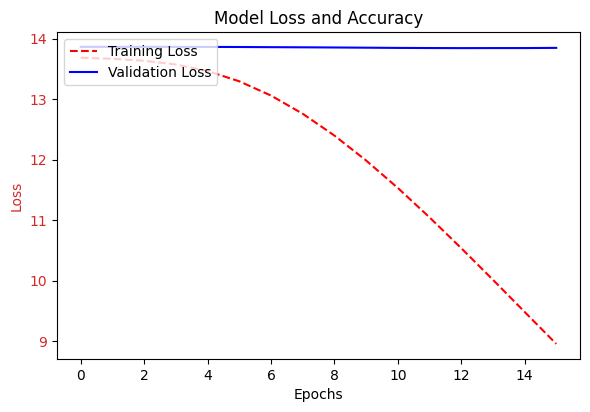

In [68]:
if archiqture[1] == 1:
    history_mda1 = train_model(model_a1, [x_train['userId'], x_train['movieId']], y_train, [x_test['userId'], x_test['movieId']], y_test)
    plot_loss(history_mda1)
    # Llamar a la función para calcular métricas
    # calcular_metricas(model_a1, [x_test['userId'], x_test['movieId']], y_test)

# A2

Epoch 1/150
88/88 [==============================] - 2s 6ms/step - loss: 10.4698 - val_loss: 6.3548
Epoch 2/150
88/88 [==============================] - 0s 4ms/step - loss: 3.1061 - val_loss: 1.2703
Epoch 3/150
88/88 [==============================] - 0s 4ms/step - loss: 1.2208 - val_loss: 1.0611
Epoch 4/150
88/88 [==============================] - 0s 5ms/step - loss: 1.1524 - val_loss: 1.0564
Epoch 5/150
88/88 [==============================] - 0s 4ms/step - loss: 1.1316 - val_loss: 1.0657
Epoch 6/150
88/88 [==============================] - 0s 4ms/step - loss: 1.0386 - val_loss: 1.0832
Epoch 7/150
88/88 [==============================] - 0s 4ms/step - loss: 0.8833 - val_loss: 1.1081
Epoch 7: early stopping


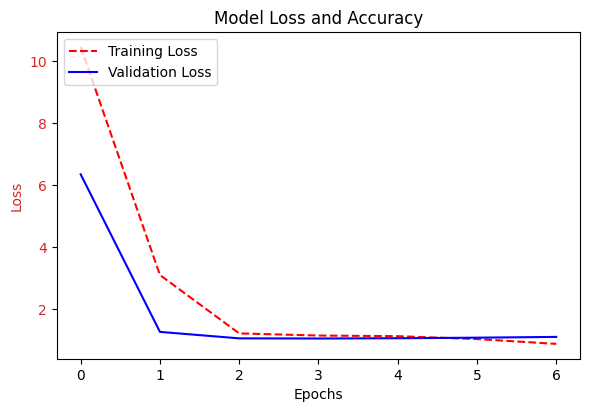

In [69]:
if archiqture[2] == 1:
    history_mda2 = train_model(model_a2, [x_train['userId'], x_train['movieId']], y_train, [x_test['userId'], x_test['movieId']], y_test)
    plot_loss(history_mda2)
    # calcular_metricas(model_a2, [x_test['userId'], x_test['movieId']], y_test)

# A3

Epoch 1/150
88/88 [==============================] - 2s 7ms/step - loss: 9.9698 - accuracy: 0.0109 - val_loss: 4.9425 - val_accuracy: 0.0151
Epoch 2/150
88/88 [==============================] - 0s 4ms/step - loss: 2.0868 - accuracy: 0.0197 - val_loss: 1.0680 - val_accuracy: 0.0151
Epoch 3/150
88/88 [==============================] - 0s 5ms/step - loss: 0.9695 - accuracy: 0.0197 - val_loss: 0.9569 - val_accuracy: 0.0151
Epoch 4/150
88/88 [==============================] - 0s 4ms/step - loss: 0.7520 - accuracy: 0.0197 - val_loss: 0.9702 - val_accuracy: 0.0151
Epoch 5/150
88/88 [==============================] - 0s 4ms/step - loss: 0.6360 - accuracy: 0.0197 - val_loss: 1.0257 - val_accuracy: 0.0151
Epoch 6/150
88/88 [==============================] - 0s 4ms/step - loss: 0.5586 - accuracy: 0.0197 - val_loss: 1.0562 - val_accuracy: 0.0151
Epoch 6: early stopping


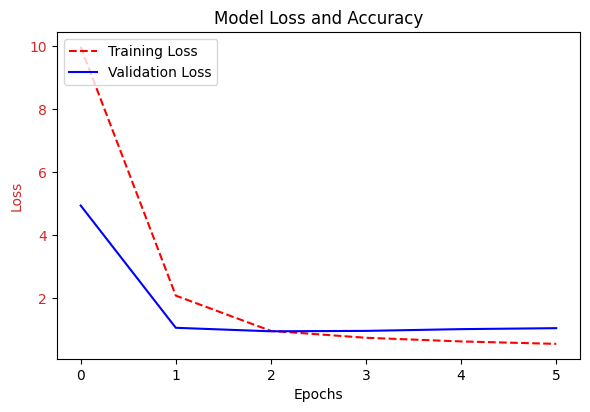

In [70]:
if archiqture[3] == 1:
    history_mda3 = train_model(model_a3, [x_train['userId'], x_train['movieId']], y_train, [x_test['userId'], x_test['movieId']], y_test)
    plot_loss(history_mda3)
    # calcular_metricas(model_a3, [x_test['userId'], x_test['movieId']], y_test)

# A4

Epoch 1/150
88/88 [==============================] - 1s 5ms/step - loss: 13.6830 - val_loss: 13.8616
Epoch 2/150
88/88 [==============================] - 0s 4ms/step - loss: 13.6650 - val_loss: 13.8615
Epoch 3/150
88/88 [==============================] - 0s 3ms/step - loss: 13.6346 - val_loss: 13.8609
Epoch 4/150
88/88 [==============================] - 0s 3ms/step - loss: 13.5761 - val_loss: 13.8594
Epoch 5/150
88/88 [==============================] - 0s 3ms/step - loss: 13.4724 - val_loss: 13.8560
Epoch 6/150
88/88 [==============================] - 0s 4ms/step - loss: 13.3095 - val_loss: 13.8508
Epoch 7/150
88/88 [==============================] - 0s 3ms/step - loss: 13.0807 - val_loss: 13.8436
Epoch 8/150
88/88 [==============================] - 0s 3ms/step - loss: 12.7875 - val_loss: 13.8339
Epoch 9/150
88/88 [==============================] - 0s 4ms/step - loss: 12.4334 - val_loss: 13.8225
Epoch 10/150
88/88 [==============================] - 0s 3ms/step - loss: 12.0273 - val_los

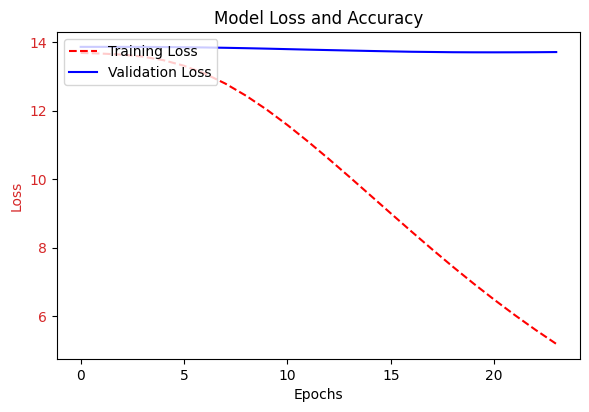

In [71]:
if archiqture[4] == 1:
    history_mda4 = train_model(model_a4, [x_train['userId'], x_train['movieId']], y_train, [x_test['userId'], x_test['movieId']], y_test)
    plot_loss(history_mda4)
    # calcular_metricas(model_a4, [x_test['userId'], x_test['movieId']], y_test)

# A5

Epoch 1/150
88/88 [==============================] - 2s 6ms/step - loss: 5.6436 - val_loss: 1.0156
Epoch 2/150
88/88 [==============================] - 0s 4ms/step - loss: 0.8688 - val_loss: 0.8841
Epoch 3/150
88/88 [==============================] - 0s 4ms/step - loss: 0.5654 - val_loss: 0.9458
Epoch 4/150
88/88 [==============================] - 0s 4ms/step - loss: 0.3975 - val_loss: 1.0038
Epoch 5/150
88/88 [==============================] - 0s 4ms/step - loss: 0.3220 - val_loss: 1.0434
Epoch 5: early stopping


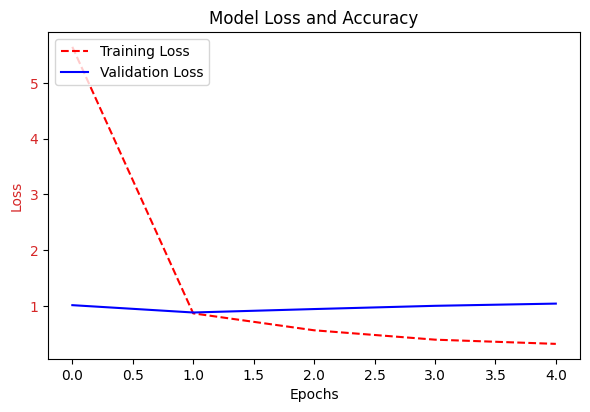

In [72]:
if archiqture[5] == 1:
    history_mda5 = train_model(model_a5, [x_train['userId'], x_train['movieId']], y_train, [x_test['userId'], x_test['movieId']], y_test)
    plot_loss(history_mda5)
    # calcular_metricas(model_a5, [x_test['userId'], x_test['movieId']], y_test)

# A6

Epoch 1/150
88/88 [==============================] - 1s 5ms/step - loss: 13.5685 - val_loss: 13.6154
Epoch 2/150
88/88 [==============================] - 0s 4ms/step - loss: 13.2601 - val_loss: 13.3679
Epoch 3/150
88/88 [==============================] - 0s 4ms/step - loss: 12.9385 - val_loss: 13.1238
Epoch 4/150
88/88 [==============================] - 0s 4ms/step - loss: 12.5957 - val_loss: 12.8856
Epoch 5/150
88/88 [==============================] - 0s 4ms/step - loss: 12.2191 - val_loss: 12.6528
Epoch 6/150
88/88 [==============================] - 0s 4ms/step - loss: 11.8002 - val_loss: 12.4252
Epoch 7/150
88/88 [==============================] - 0s 4ms/step - loss: 11.3365 - val_loss: 12.2060
Epoch 8/150
88/88 [==============================] - 0s 3ms/step - loss: 10.8345 - val_loss: 11.9936
Epoch 9/150
88/88 [==============================] - 0s 4ms/step - loss: 10.2988 - val_loss: 11.7888
Epoch 10/150
88/88 [==============================] - 0s 4ms/step - loss: 9.7388 - val_loss

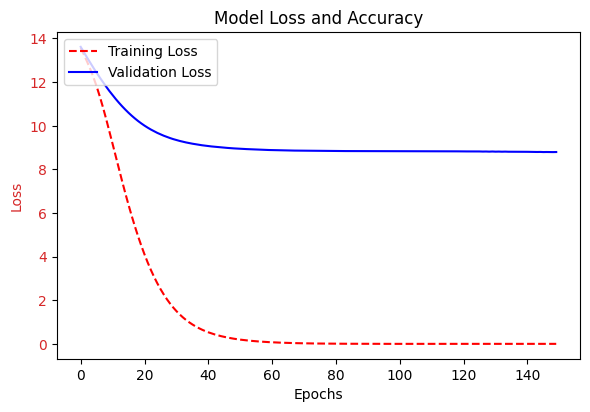

In [73]:
if archiqture[6] == 1:
    history_mda6 = train_model(model_a6, [x_train['userId'], x_train['movieId']], y_train, [x_test['userId'], x_test['movieId']], y_test)
    plot_loss(history_mda6)
    # calcular_metricas(model_a6, [x_test['userId'], x_test['movieId']], y_test)

# A7

In [74]:
if archiqture[7] == 1:
    history_mda7 = train_model(model_a7, [x_train['userId'], x_train['movieId']], y_train, [x_test['userId'], x_test['movieId']], y_test)
    plot_loss(history_mda7)
    # calcular_metricas(model_a7, [x_test['userId'], x_test['movieId']], y_test)

# A8

In [75]:
if archiqture[8] == 1:
    # history_mda8 = modelo_a8.fit([x_train['userId'], x_train['movieId'], generos_one_hot_train], y_train, epochs=10, batch_size=128, validation_data=([x_test['userId'], x_test['movieId'], generos_one_hot_test], y_test))
    history_mda8 = train_model(modelo_a8, [x_train['userId'], x_train['movieId'], generos_one_hot_train], y_train, [x_test['userId'], x_test['movieId'], generos_one_hot_test], y_test)
    plot_loss(history_mda8)
    calcular_metricas(modelo_a8, [x_test['userId'], x_test['movieId']], y_test, generos_one_hot[dfUser_test.index])


## Evaluación de Modelos de Recomendación para Usuarios con Múltiples Calificaciones

 Utiliza varios modelos de recomendación para predecir las calificaciones que este usuario podría otorgar a otras películas, proporcionando una evaluación exhaustiva del rendimiento de los modelos para usuarios activos.

In [76]:
x_test

,userId,movieId,genres
0,24,2443,Adventure|Fantasy|IMAX
1,339,251,Action|Crime|Drama|IMAX
2,823,3174,Action|Comedy|Horror|Sci-Fi
3,35,37,Drama
4,209,316,Comedy|Fantasy|Horror
...,...,...,...
1389,22,486,Action|Adventure|Animation|Children|Comedy|IMAX
1390,607,2914,Action|Drama|Romance|War
1391,80,2440,(no genres listed)
1392,98,587,Drama|Horror|Thriller


In [77]:
y_test

0       4.0
1       4.0
2       5.0
3       3.5
4       4.5
       ... 
1389    4.5
1390    4.0
1391    3.0
1392    3.5
1393    2.0
Name: rating, Length: 1394, dtype: float64

In [78]:
def unificar_predicciones(df_real, predicciones):
    # Ordenar el DataFrame de calificaciones reales por rating de manera descendente
    df_ordenado = df_real.sort_values(by='rating', ascending=False)
    df_real = df_ordenado.reset_index(drop=True)
    df_real = df_real[['userId', 'movieId', 'rating']]

    # Convertir la lista de predicciones a un DataFrame
    df_predicciones = pd.DataFrame(predicciones, columns=['rating_predicho'])

    # Reiniciar el índice de df_test_by_unq_user para asegurar que coincida con el índice de predicciones
    df_test_by_unq_user_reset = df_real.reset_index(drop=True)

    # Agregar la columna de índices (movieId) al DataFrame de predicciones
    df_predicciones['movieId_predict'] = df_test_by_unq_user_reset['movieId']

    # Ordenar el DataFrame de predicciones por rating de manera descendente
    df_predicciones_ordenado = df_predicciones.sort_values(by='rating_predicho', ascending=False)
    df_predicciones_ordenado = df_predicciones_ordenado.reset_index(drop=True)

    # Ordenar por rating_predicho
    df_predicciones_ordenado = df_predicciones_ordenado.sort_values(by='rating_predicho', ascending=False)

    # Concatenar horizontalmente
    df_concatenado = pd.concat([df_real, df_predicciones_ordenado], axis=1)

    # Reordenar columnas y renombrar
    df_concatenado = df_concatenado[['userId', 'movieId', 'rating', 'rating_predicho', 'movieId_predict']]

    return df_concatenado

In [79]:

# # Encuentra los valores que se repiten al menos n veces
# n = 10
# valores_repetidos = x_test['userId'].value_counts()
# valores_cumplen_criterio = valores_repetidos[valores_repetidos >= n]

# if not valores_cumplen_criterio.empty:
#     user = random.choice(valores_cumplen_criterio.index)
#     print(f"Usuario con al menos {n} calificaciones (seleccionado aleatoriamente):", user)
# else:
#     print(f"No hay usuarios con al menos {n} calificaciones.")


In [80]:
user = random.choice(x_test['userId'].index)
x_test[(x_test['userId'] == user)]


,userId,movieId,genres


In [81]:
#Concatenar el dataframe de test con el objeto series de claificaciones
df_x_test_y_test_concat = pd.concat([x_test, y_test], axis=1)
#Obtenemos un dataframe para un único usuario
dfUser_test= df_x_test_y_test_concat.loc[df_x_test_y_test_concat['userId'] == user]
#Obtenemos un objeto Series con la columna rating a predecir.
rating_df_user = dfUser_test['rating']
# rating_df_user

In [82]:
# Ordenar el DataFrame de calificaciones reales por rating de manera descendente
dfUser_test_real_order_by_rating = dfUser_test.sort_values(by='rating', ascending=False)
dfUser_test_real = dfUser_test_real_order_by_rating.copy()
dfUser_test_real = dfUser_test_real.reset_index(drop=True)
dfUser_test_real = dfUser_test_real[['userId', 'movieId', 'rating']]
# print(dfUser_test_real)

In [83]:
def get_relevant_value_by_user(calificaciones):
  # Se van a obtner el número de elementos relevantes para un usario
  # Se decide que un elemento es relevante para unusuario si lo ha calificado con más de 3'5, es decir elementos
  # calificados con 4, 4'5 y 5. Cualquier calificación real inferior a 3,5 es irrelevante
  # Inicializamos un contador para el número de elementos relevantes
  relevantes = 0

  # Iteramos sobre las calificaciones
  for calificacion in calificaciones:
    # Si la calificación es mayor que 3.5, consideramos el elemento como relevante
    if calificacion >= 3.5:
      relevantes += 1
  return relevantes

In [84]:
def obtain_true_dataframe_test_by_user(x_test, y_test, user_id):
  #Concatenar el dataframe de test con el objeto series de claificaciones
  dfTets_x_y = pd.concat([x_test, y_test], axis=1)
  #Obtenemos un dataframe para un único usuario
  dfTest_by_user= dfTets_x_y.loc[dfTets_x_y['userId'] == user_id]

  # Ordenar el DataFrame de calificaciones reales por rating de manera descendente
  dfTest_by_user_order_rating = dfTest_by_user.sort_values(by='rating', ascending=False)
  dfTets_Real_by_user = dfTest_by_user_order_rating.copy()
  dfTets_Real_by_user = dfTets_Real_by_user.reset_index(drop=True)
  dfTets_Real_by_user = dfTets_Real_by_user[['userId', 'movieId', 'rating']]
  return dfTets_Real_by_user


In [100]:
def obtain_precission_recall_by_user(df_test_true_uq_user, modelo):
  predicciones = modelo.predict([df_test_true_uq_user['userId'], df_test_true_uq_user['movieId']], verbose=0)
  # print(f"Mtricas de predicción: ")
  # calcular_metricas(modelo, [x_test['userId'], x_test['movieId']], y_test)

  df_unificado = unificar_predicciones(df_test_true_uq_user, predicciones)

  num_relevant_values = get_relevant_value_by_user(df_unificado['rating'])

  relevants_movvies_per_user = list(df_unificado['movieId'][:num_relevant_values])

  precision_value_k_point = precisionK(list(df_unificado['movieId_predict']),
                                       relevants_movvies_per_user, 5)

  recall_value_k_point = recallK(list(df_unificado['movieId_predict']),
                                 relevants_movvies_per_user, 5)

  # print(f"Precisión@K: {precision_value_k_point:.2f}")
  # print(f"Recall@K: {recall_value_k_point:.2f}\n")

  return precision_value_k_point, recall_value_k_point, relevants_movvies_per_user, list(df_unificado['movieId_predict']), predicciones


In [101]:
# lista_modelos = [model_a1, model_a2, model_a3, model_a4, model_a5, model_a6]
lista_modelos = [model_a3]

# Obtener la lista de usuarios únicos
lista_usuarios_unicos = x_test['userId'].unique()
num_user_uq = len(lista_usuarios_unicos)
# Iteramos sobre las calificaciones
list_recomendeds = []
list_relevants = []
list_predictions_ratings = []

for i, modelo in enumerate(lista_modelos, start=1):
  if archiqture[i] == 1:
    print(f"-------------------> MODELO {i}")
    for unique_user in lista_usuarios_unicos:
      dfTets_true_by_user = obtain_true_dataframe_test_by_user(x_test, y_test, unique_user)
      precsion, recall, relevant_items_list, recommended_items_list, predicted_ratings = obtain_precission_recall_by_user(dfTets_true_by_user, modelo)
      list_recomendeds.append(recommended_items_list)
      list_relevants.append(relevant_items_list)
      list_predictions_ratings.append(predicted_ratings)

    mrr = mean_reciprocal_rank(list_recomendeds, list_relevants)
    map_value = mean_average_precision(list_recomendeds, list_relevants)
    ndcg_avg = mean_normalized_discounted_cumulative_gain(list_recomendeds, list_relevants)
    catalog_items = set(x_test['movieId'])
    coverage = catalog_coverage(list_recomendeds, catalog_items)

    print(f"MRR: {mrr:.2f}\n")
    print(f"MAP: {map_value:.2f}\n")
    print(f"nDGC Average: {ndcg_avg:.2f}\n")
    print(f"Catalog Coverage: {coverage}")

-------------------> MODELO 1
MRR: 0.66

MAP: 0.78

nDGC Average: 0.80

Catalog Coverage: 1.0


In [105]:
len(catalog_items)

1166

In [87]:
# # Mostrar algunas predicciones de cada uno de los modelos, dado un subDataframe de un usuario
# for i, modelo in enumerate(lista_modelos, start=1):
#     if archiqture[i] == 1:
#         if i == 8:
#             predicciones = modelo.predict([dfUser_test['userId'], dfUser_test['movieId'], generos_one_hot[dfUser_test.index]])
#         else:
#             predicciones = modelo.predict([dfUser_test['userId'], dfUser_test['movieId']])
#         # print(f"Predicciones del modelo {i}:")
#         # df_unificado = unificar_predicciones(dfUser_test_real, predicciones)
#         # print(df_unificado)

In [88]:
# # Ordenar el DataFrame de calificaciones reales por rating de manera descendente
# df_ordenado = df_test_by_unq_user.sort_values(by='rating', ascending=False)
# df_real = df_ordenado.copy()
# df_real = df_real.reset_index(drop=True)
# df_real = df_real[['userId', 'movieId', 'rating']]
# # Convertir la lista de predicciones a un DataFrame
# df_predicciones = pd.DataFrame(predicciones, columns=['rating_predicho'])

# # Reiniciar el índice de df_test_by_unq_user para asegurar que coincida con el índice de predicciones
# df_test_by_unq_user_reset = df_test_by_unq_user.reset_index(drop=True)

# # Agregar la columna de índices (movieId) al DataFrame de predicciones
# df_predicciones['movieId_predict'] = df_test_by_unq_user_reset['movieId']

# # Ordenar el DataFrame de predicciones por rating de manera descendente
# df_predicciones_ordenado = df_predicciones.sort_values(by='rating_predicho', ascending=False)
# df_predicciones_ordenado = df_predicciones_ordenado.reset_index(drop=True)
# # Convertir a DataFrame
# df_real = df_real
# df_predicho = df_predicciones_ordenado

# # Ordenar por rating_predicho
# df_predicho = df_predicho.sort_values(by='rating_predicho', ascending=False)

# # Concatenar horizontalmente
# df_concatenado = pd.concat([df_real, df_predicho], axis=1)

# # Reordenar columnas y renombrar
# df_concatenado = df_concatenado[['userId', 'movieId', 'rating', 'rating_predicho', 'movieId_predict']]


# df_concatenado.head(5)



# Model Evaluation

Intentamos medir el rendimiento del modelo proporcionando productos candidatos al modelo y evaluando los resultados. Los productos candidatos se combinan con 49 productos seleccionados entre los productos no comprados y un producto objetivo representado en la variable output_sequence. Si el producto objetivo aparece en los k primeros resultados del modelo, lo consideramos un acierto.

Por otro lado; Hidasi y Karatzoglou (2018) definen "recall@k" como una métrica de evaluación como "la proporción de casos que tienen el elemento deseado entre los primeros k elementos en todos los casos de prueba." Además, otra métrica de evaluación es "MRR@k", que es la media de los rangos recíprocos de los ítems objetivo. El rango recíproco se fija en cero si el rango es superior a k.